<a href="https://colab.research.google.com/github/danielegenta/Progetto-MLDL/blob/lwf/main_lwf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
  Following the iCaRL paper specifications,
  LwF is implemented simirality to iCaRL itself.
  The differences are:
  - No exemplars management
  - For classification, it is used the network output values themselves
  (ref. iCaRL paper section 4.1)
"""

'\n  Following the iCaRL paper specifications,\n  LwF is implemented simirality to iCaRL itself.\n  The differences are:\n  - No exemplars management\n  - For classification, it is used the network output values themselves\n  (ref. iCaRL paper section 4.1)\n'

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
import random


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
DATA_DIR = 'DATA' # here the dataset will be downloaded

# Clone github repository with dataset handler
!rm -r Cifar100/
#!rm -r $DATA_DIR
#!mkdir "DATA"
if not os.path.isdir('./Cifar100'):
  !git clone -b lwf https://github.com/danielegenta/Progetto-MLDL.git
  !mv 'Progetto-MLDL' 'Cifar100'
  !rm -r Cifar100/Theoretical-Sources
  !rm -rf Cifar100/ProjectMLDL.ipynb

Cloning into 'Progetto-MLDL'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 570 (delta 42), reused 45 (delta 21), pack-reused 502
Receiving objects: 100% (570/570), 3.99 MiB | 2.49 MiB/s, done.
Resolving deltas: 100% (328/328), done.


In [4]:
# Download dataset from the official source and save it into DATA/cifar-100-pyhton

if not os.path.isdir('./{}'.format("$DATA_DIR/cifar-100-python")):
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
    !tar -xf 'cifar-100-python.tar.gz'  
    !mkdir $DATA_DIR
    !mv 'cifar-100-python' "$DATA_DIR/cifar-100-python"
    !rm -rf 'cifar-100-python.tar.gz'

--2020-05-26 22:12:55--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  14.0MB/s    in 13s     

2020-05-26 22:13:09 (12.3 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

mkdir: cannot create directory ‘DATA’: File exists
mv: cannot move 'cifar-100-python' to 'DATA/cifar-100-python/cifar-100-python': Directory not empty


In [5]:
from Cifar100 import utils

dictHyperparams = utils.getHyperparams()
print(dictHyperparams)

DEVICE = dictHyperparams["DEVICE"] # 'cuda' or 'cpu'
NUM_CLASSES = dictHyperparams["NUM_CLASSES"] 

BATCH_SIZE = dictHyperparams["BATCH_SIZE"]     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = dictHyperparams["LR"]          # The initial Learning Rate
MOMENTUM = dictHyperparams["MOMENTUM"]       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = dictHyperparams["WEIGHT_DECAY"] # Regularization, you can keep this at the default

NUM_EPOCHS = dictHyperparams["NUM_EPOCHS"]     # Total number of training epochs (iterations over dataset)
GAMMA = dictHyperparams["GAMMA"]         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = dictHyperparams["LOG_FREQUENCY"]
MILESTONES = dictHyperparams["MILESTONES"]
RANDOM_SEED = dictHyperparams["SEED"]

{'LR': 2, 'MOMENTUM': 0.9, 'WEIGHT_DECAY': 1e-05, 'NUM_EPOCHS': 70, 'MILESTONES': [49, 63], 'BATCH_SIZE': 128, 'DEVICE': 'cuda', 'GAMMA': 0.2, 'SEED': 30, 'LOG_FREQUENCY': 10, 'NUM_CLASSES': 100}


In [0]:
train_transform, eval_transform = utils.getTransformations()

In [7]:
from Cifar100.Dataset.cifar100 import CIFAR100

# Import dataset
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# check if datasets have been correctly loaded
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [0]:
from Cifar100.reverse_index import ReverseIndex

def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = list(reverse_index.getGroups())
    for g in groups:
        labels_of_groups = reverse_index.getLabelsOfGroup(g)
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

In [0]:
# performing the train/val split
train_splits = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
outputs_labels_mapping = ReverseIndex(train_dataset, train_splits)

# performing the test split (coherent with train/val)
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,10):
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

**LWF implementation**

In [11]:
# default params
from Cifar100.lwf_model import LWF

feature_size = 2048
n_classes = 0
lwf = LWF(feature_size, n_classes, BATCH_SIZE, WEIGHT_DECAY, LR, GAMMA, NUM_EPOCHS, DEVICE,MILESTONES,MOMENTUM, outputs_labels_mapping)
lwf.cuda()

LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, 

In [0]:
def joinSubsets(dataset, subsets):
    indices = []
    for s in subsets:
        indices += s.indices
    return Subset(dataset, indices)

In [0]:
def incrementalTraining(net, train_subsets, val_subsets, test_subsets,eval_transform, reverse_index):
    #groups_accuracies=[] not used right now, use it if you want test on single groups
    all_accuracies = []
    all_preds_cm = []
    all_labels_cm = []
    group_id=1
    test_set = None
    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      print("GROUP: ",group_id)
      if test_set is None:
        test_set = test_subset
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])

      train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
      val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE,shuffle=False, num_workers=4)
      test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE,shuffle=False, num_workers=4)
      
      #net.train()

      new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)

      # update representation
      net.update_representation(train_subset, new_classes_examined)

      # evaluation on the train set
      net.eval()
      total = 0.0
      correct = 0.0

      for indices, images, labels in train_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels = reverse_index.getNodes(labels)
        preds = net.classify(images)
        correct += torch.sum(preds == labels.data).data.item()

      # Train Accuracy
      print ('Train Accuracy (on current group): %.2f\n' % (100.0 * correct / len(train_subset)))

      # evaluation on all the previous groups
      #net.eval()
      total = 0.0
      correct = 0.0

      for indices, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels = reverse_index.getNodes(labels)
        preds = net.classify(images)
        correct += torch.sum(preds == labels.data).data.item()
      
      all_preds_cm.extend(preds.tolist())
      all_labels_cm.extend(labels.data.tolist())

      accuracy = correct / len(test_set)
      all_accuracies.append(accuracy)
      # Train Accuracy
      print ('Test Accuracy (all groups seen so far): %.2f\n' % (100.0 * accuracy))

      net.n_known = net.n_classes
      print ("the model knows %d classes:\n " % net.n_known)

      group_id+=1
    
    return all_accuracies, np.array(all_preds_cm), np.array(all_labels_cm)

      

In [14]:
accuracies, all_preds_cm, all_labels_cm = incrementalTraining(lwf, train_subsets, val_subsets, test_subsets,eval_transform, outputs_labels_mapping)

GROUP:  1
NUM_EPOCHS:  0 / 70
LOSS:  tensor(0.3102, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
NUM_EPOCHS:  1 / 70
LOSS:  tensor(0.2494, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
NUM_EPOCHS:  2 / 70
LOSS:  tensor(0.2278, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
NUM_EPOCHS:  3 / 70
LOSS:  tensor(0.2038, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
NUM_EPOCHS:  4 / 70
LOSS:  tensor(0.2187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
NUM_EPOCHS:  5 / 70
LOSS:  tensor(0.2204, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
NUM_EPOCHS:  6 / 70
LOSS:  tensor(0.1848, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
NUM_EPOCHS:  7 / 70
LOSS:  tensor(0.1600, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
NUM_EPOCHS:  8 / 70
LOSS:  tensor(0.1957, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
NUM_EPOCHS:  9 / 70
LOSS:  

96


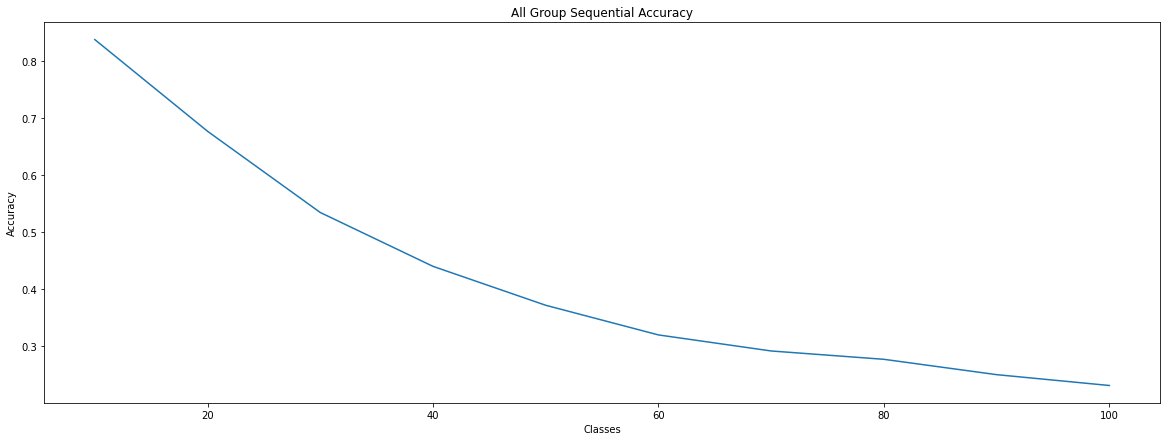

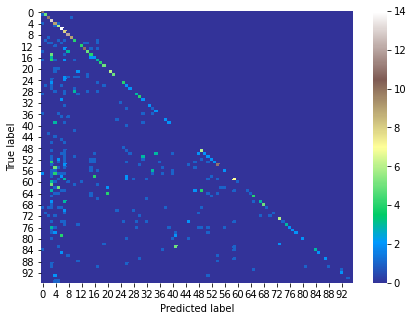

metrics FINETUNING for seed 30


IndexError: ignored

In [18]:
# metrics

# accuracy 
data_plot_line=[]

for id in range(0,10):
    data_plot_line.append(((id+1)*10, accuracies[id]))

# plot accuracy trend
utils.plotAccuracyTrend(data_plot_line)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
utils.plotConfusionMatrix(confusionMatrixData)

# write to file
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))
utils.writeMetrics('lwf', RANDOM_SEED, accuracies, confusionMatrixData)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 60,
 61,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 81,
 82,
 85,
 86,
 88,
 89,
 96,
 98}